# Gene set enrichment and pathway analysis 

## Motivation

Single-cell RNA-seq provides unprecedented insights into molecular variations at the cell-type level across conditions, tissue types, species and individuals. The high-throughput nature of scRNA-seq makes it hard to interpret the obtained results, since hundreds of genes might be explaining the observed variability in a particular biological context. **Gene set enrichment analysis**, also known as pathway analysis or functional analysis, allows the summarization of highly-dimensional molecular insights into interpretable terms such as biological processes or pathways, which enable a better understanding of the obtained results and the generation of mechanistic hypothesis.

Functional analysis requires three different inputs:

* **Molecular readouts**: a matrix containing gene values, either for single cells or samples (normalized gene expression counts), or from population comparisons (log fold changes, contrast statistics).
* **Prior knowledge**: collection of gene sets or footprints associated to biological processes (e.g. epithelial to mesechymal transition, metabolism etc) or regulatory pathways (e.g. MAPK signalling).
* **Enrichment method**: statistical method that computes the "enrichment" or "activity" scores of the gene sets from the molecular data.

In this chapter, we first provide an introduction to gene sets and commonly used databases, distinguish between gene sets and footprints, describe how functional enrichment can be applied to single cell data, list several enrichment methods and their different modeling strategies and discuss best practices. We conclude the chapter by showing practical examples. Note that we use the terms pathway analysis, enrichment analysis, gene set analysis and functional analysis interchangeably in this chapter.

## Gene set collections

Gene sets are a curated list of genes that are known to be involved in a biological process through previous studies and/or experiments and are stored in prior knowledge databases. The Molecular Signatures Database (MSigDB) {cite}`subramanian2005gene,liberzon2011molecular` is the most comprehensive database consisting of 9 collections of gene sets. Some commonly used collections are C5, which is the gene ontology (GO) collection, C2 collection of curated gene signatures from published studies that are typically context (e.g. tissue, condition) specific, but also include KEGG and REACTOME gene signatures. For cancer studies, the Hallmark collection is commonly used, and for immunologic studies the C7 collection is a common choice. Note that these signatures are mainly derived from Bulk-seq measurements and measure continuous phenotypes. Recently and with the wide-spread availability of scRNA-seq datasets, databases have evolved that provide curated marker lists derived from published single cell studies that define cell types in various tissues and species. These include CellMarker {cite}`zhang2019cellmarker` and PanglaoDB {cite}`franzen2019panglaodb`. Curated marker lists are not limited to those made available in databases, and can be curated by oneself using own or public data.

Despite their wide use, gene sets have some limitations. They assume that each gene holds the same importance in a given biological process, and they contain both positively and negatively associated genes without making any distinction between them. Moreover, gene sets usually only contain protein members of a given pathway, which assumes a strong correlation between gene expression, protein abundance, and protein activity {cite}`szalai2020pwmethods`. **Footprints** are a richer definition of gene sets since they contain interaction weights for each gene in the set, denoting its strength and mode of regulation. Instead of focusing on the protein members of a biological process, they contain the genes that change downstream of said process when it was active, making them easier to use with transcriptomics data {cite}`dugourd2019footprint`. Known databases of footprints include PROGENy {cite}`schubert2018perturbation` for signaling pathways, CytoSig {cite}`jiang2021cytocig` for ligand signatures, and *DoRothEA* {cite}`garcia2019benchmark` for transcription factors. Similar to gene sets, these can be curated by oneself derived in a data-driven manner, for example by generating [Gene Regulatory Networks](https://www.sc-best-practices.org/mechanisms/grns.html).

## Applications in single-cell data

In scRNA-seq data analysis, enrichment is generally carried out on clusters of cells or cell types, one-at-a-time. For example, one can test how genes change between untreated and treated cells per cell-type and use the obtained gene statistics to see what biological processes are deregulated {cite}`squair2021psbulk, crowell2020muscat`. Here any complex experimental design can be used while adjusting for batch effects, between-individual variations, gender, strain differences in mouse models, etc. (check the [Differential gene expression analysis](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) chapter for best practices). 

Alternatively, enrichment methods can also be applied directly to the gene expression data of individual cells with the main objective to reduce highly-dimensional expression data into a collection of interpretable latent variables to explore their variability. This dimensionality reduction driven by prior knowledge increases the power of population comparisons, while keeping biological significance. Compared to other data-driven dimensionality reduction methods like principal component analysis or factor analysis, the estimated latent variables  generated from enrichment methods are not necessarily independent.

Most enrichment methods have been previously developed for bulk RNA-seq but can be applied to single-cell data. Holland et al. {cite}`holland2020robustness` found that methods have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single-cell data. Holland et al. also concluded that enrichment inference is more sensitive to the choice of gene sets (the prior knowledge used) rather than the statistical methods. This observation though can be explained by the fact that biological processes might be context-specific; for example TF-target associations in one cell-type may actually differ from another cell-type or tissue. There are different strategies to contextualize gene sets, such as inferring [Gene Regulatory Networks](https://www.sc-best-practices.org/mechanisms/grns.html), or performing factor analysis influenced by prior, as seen in Muvi {cite}`qoku2022muvi` and Spectra {cite}`kunes2022spectra`.

In contrast to Holland et al., Zhang et al. {cite}`zhang2020benchmarking` found that single-cell-based tools, specifically Pagoda2, outperform some bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that functional inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

## Enrichment methods

Most enrichment methods are based on hypergeometric tests, rank statistics or empirical estimations of likelihoods based on permutations. Regardless of the statistical method used, their hypothesis tests can be divided in two main classes: competitive or self-contained as defined by Goeman and Buhlmann (2007) {cite}`goeman2007analyzing`. A competitive test tests whether the genes in the set are highly ranked relative to the genes not in the set (usually of the same size). The sampling unit here is genes, so the test can be done with a single sample or contrast vector. In self-contained gene set testing, the sampling unit is the subject, so multiple samples per group are required, but it is not required to have genes that are not present in the set. A self-contained test tests whether genes in the test set are differentially expressed without regard to any other gene measured in the dataset. Competitive hypotheses are the most used in enrichment analysis because they depend solely on a single vector of gene-level statistics compared to self-contained methods which are limited by the number of samples {cite}`mathur2018gsetcomp`. In a recent benchmark {cite}`geistlinger2020gsetbench`, it has been shown that self-contained methods might be quite sensitive since they can identify gene sets as enriched while containing only a single differentially expressed gene. On the other hand, competitive methods might be more restrictive by testing for excess of differential expression in the gene set when compared to the background level, coming closer to the intuition of an enrichment and tend to rank relevant gene sets systematically higher than self-contained methods. However, it is important to keep in mind that each approach has its pros an cons and that these distinctions between the two null hypotheses make differences to the interpretation of gene set enrichment results.

Common competitive enrichment methods include simple hypergeomtric tests or one-tailed Fisher's exact test (as in *Enrichr* {cite}`chen2013enrichr`), the GSEA algorithm {cite}`subramanian2005gene` and its fast implementation (fgsea) {cite}`korotkevich2021fast`, GSVA {cite}`hanzelmann2013gsva`, VISION {cite}`detomaso2019functional`, AUCell {cite}`aibar2017scenic`, Pagoda2 {cite}`fan2016characterizing, lake2018integrative`, camera (as in limma {cite}`ritchie2015limma`), scDECAF (https://github.com/DavisLaboratory/scDECAF) and simple combined z-score {cite}`lee2008inferring`. As mentioned before, while less computational tools that implement these methods use self-contained hypothesis tests, notable examples are roast and fry, both available in the differential testing framework limma {cite}`ritchie2015limma`. These methods leverage linear models and Empirical Bayes moderation of test statistics {cite}`smyth2005limma`. Note that while most methods work downstream of differential gene testing, methods included in the limma framework (camera, roast and fry) start from the sample level gene expression data. Detailed explanations on these methods can be found in the [*limma* user manual](https://bioconductor.org/packages/release/bioc/manuals/limma/man/limma.pdf).

There are also enrichment methods that leverage footprints when inferring scores, i.e. they accommodate the usage of gene weights. Common competitive enrichment methods that leverage footprints include VIPER {cite}`alvarez2016viper`, ULM and MLM {cite}`badia2022decoupler`. To the best of our knowledge, there are no implementations of self-contained hypothesis testing methods that also leverage gene weight modeling.

Enrichment frameworks collect several enrichment methods in a single tool. These facilitate the usage of various enrichment methods on the data since they have a common format and provide utility functions to access prior knowledge resources. Some of them are [Piano](https://bioconductor.org/packages/release/bioc/html/piano.html) {cite}`varemo2013piano` and [EGSEA](https://bioconductor.org/packages/release/bioc/html/EGSEA.html) {cite}`alhamdoosh2016egsea` (available in R), and [decoupler](https://decoupler-py.readthedocs.io/en/latest/) {cite}`badia2022decoupler` (available both in R and Python).

| Method              | Type of Null Hypothesis | Weights genes | Reference                                          |
|---------------------|-------------------------|---------------|----------------------------------------------------|
| Fisher's exact test | Competitive             | No            | {cite}`chen2013enrichr`                            |
| GSEA                | Competitive             | No            | {cite}`subramanian2005gene, korotkevich2021fast`   |
| GSVA                | Competitive             | No            | {cite}`hanzelmann2013gsva`                         |
| VISION              | Competitive             | No            | {cite}`detomaso2019functional`                     |
| AUCell              | Competitive             | No            | {cite}`aibar2017scenic`                            |
| Pagoda2             | Competitive             | No            | {cite}`fan2016characterizing, lake2018integrative` |
| Camera              | Competitive             | No            | {cite}`ritchie2015limma`                           |
| scDECAF             | Competitive             | No            | https://github.com/DavisLaboratory/scDECAF         |
| Z-score             | Competitive             | No            | {cite}`lee2008inferring`                           |
| Roast               | Self-constrained        | No            | {cite}`ritchie2015limma`                           |
| Fry                 | Self-constrained        | No            | {cite}`ritchie2015limma`                           |
| VIPER               | Competitive             | Yes           | {cite}`alvarez2016viper`                           |
| ULM                 | Competitive             | Yes           | {cite}`badia2022decoupler`                         |
| MLM                 | Competitive             | Yes           | {cite}`badia2022decoupler`                         |

## Technical considerations

### Filtering out the gene sets with low number of genes 

A common practice is to exclude any gene sets with a few genes overlapping the data or Highly Variable Genes (HVG) in the pre-processing step. Zhang et al. {cite}`zhang2020benchmarking` found that the performance of both single-cell-based and bulk-based methods drops as gene coverage, that is the number of genes in pathways/gene sets, decreases. Holland et al {cite}`holland2020robustness` also found that gene sets of smaller size adversely impacts the performance of Bulk-seq  enrichment methods on single cell data. These report collectively support that filtering gene sets with few gene members, say less than 10 or 15 genes in the set, is beneficial in functional analysis. Damian & Gorfine (2004) {cite}`damian2004statistical` attributed this to the fact gene variances in gene sets with a smaller number of genes are more likely to be large, whereas gene variances in larger gene sets tend to be smaller. This impacts the accuracy of the test statistics computed to test for enrichment. Zhang et al. additionally found that pathway analysis was susceptible to normalization procedures applied to gene expression measurements.

### Data normalization

Read counts in single cell experiments are typically normalised early on in the pre-processing pipeline to ensure that measuerments are comparable across cells of various library sizes. Zhang et al. {cite}`zhang2020benchmarking` found that normalisation by *SCTransform* {cite}`hafemeister2019normalization` and *scran* {cite}`lun2016step` generally improves the performance of both single-cell- and bulk-based enrichment scoring tools. They found that the performance of *AUCell* (a rank-base method) and *z-score* (transformation to zero mean, unit standard deviation) is particularly affected by normalization with distinct methods.

## Case study: Functional analysis in human PBMC single cells

### Prepare and explore the data

We first download the 25K PBMC data and follow the standard `scanpy` workflow for normalization of read counts and subsetting on the highly variable genes. The dataset contains untreated and IFN-$\beta$ stimulated human PBMC cells {cite}`gspa:kang2018`. We explore patterns of variation in the data with UMAP representation of 4000 highly variable genes. 

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import decoupler
import seaborn as sns
import matplotlib.pyplot as plt

import session_info

In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor='white')
sc.set_figure_params(figsize=(4, 4))

In [3]:
# Filtering warnings from current version of matplotlib
import warnings

warnings.filterwarnings(
    "ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message="Tight layout not applied.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message="The `inplace` parameter in pandas.Categorical*", category=FutureWarning
)
warnings.filterwarnings(
    "ignore", message="Slicing a positional slice with .loc is not supported*", category=FutureWarning
)

In [4]:
import rpy2

rpy2.__version__

'3.5.1'

In [5]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r

%load_ext rpy2.ipython

anndata2ri.activate()

In [6]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
})

In [7]:
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [8]:
# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

# Renaming label to condition
adata.obs = adata.obs.rename({"label": "condition"}, axis=1)

# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [9]:
# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor="seurat_v3", subset=False, layer="counts"
)

In [10]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

While the current object comes with UMAP and PCA embeddings, these have been corrected for stimulation condition, which we don't want for this analysis. Instead we will recompute these.

In [11]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/badi/miniconda3/envs/pathway/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


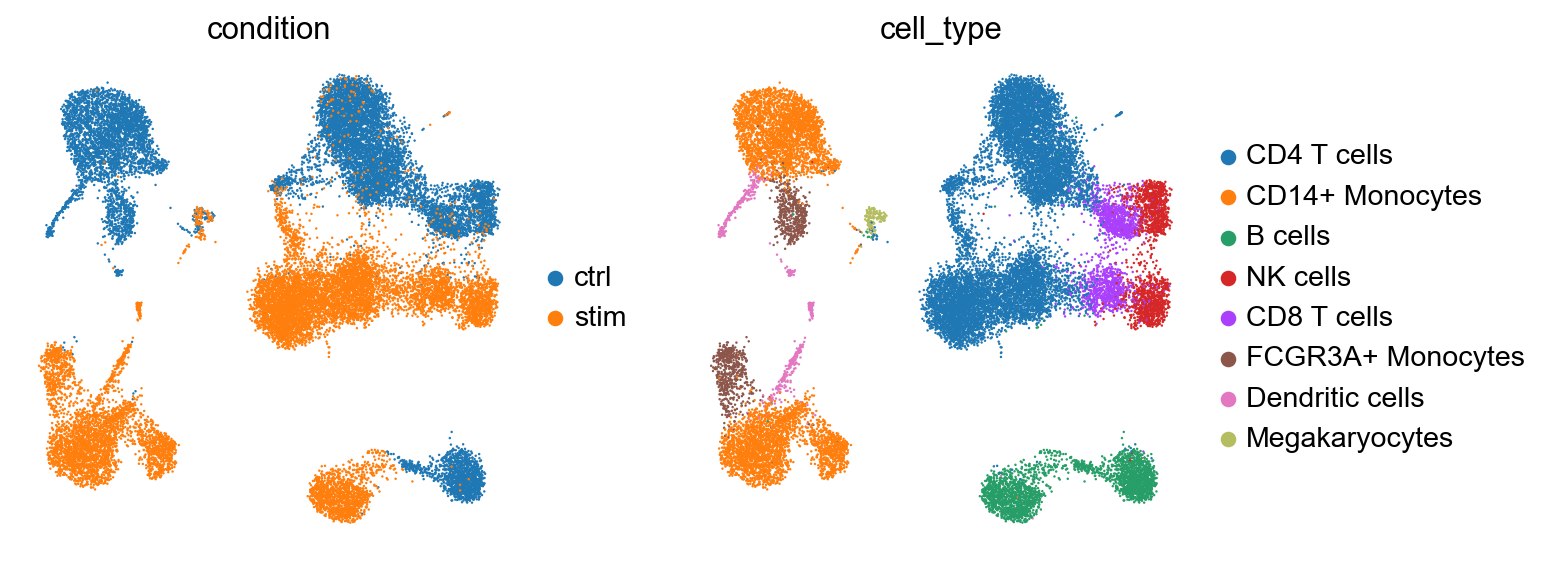

In [12]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=2,
)

### Retrieving gene sets

Gene sets can be downloaded from their respective databases, usualy they are stored in the [GMT](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats#GMT:_Gene_Matrix_Transposed_file_format_.28.2A.gmt.29) file format. Gene sets can also be retrieved from databases using wrappers, here is an example on how to download MSigDB using `decoupler` (which leverages the meta-database OmniPath {cite}`turei2021omnipath`):

```python
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB", organism='human')

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]
```

However, for stability of this tutorial we are using a fixed version of the gene set collection.

Here we download and read the GMT file for the REACTOME pathways annotated in the C2 collection of MSigDB:

In [13]:
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771
        
# Read
reactome = decoupler.read_gmt("c2.cp.reactome.v7.5.1.symbols.gmt")
reactome

source    target
0      REACTOME_INTERLEUKIN_6_SIGNALING      JAK2
1      REACTOME_INTERLEUKIN_6_SIGNALING      TYK2
2      REACTOME_INTERLEUKIN_6_SIGNALING       CBL
3      REACTOME_INTERLEUKIN_6_SIGNALING     STAT1
4      REACTOME_INTERLEUKIN_6_SIGNALING     IL6ST
...                                 ...       ...
89471    REACTOME_ION_CHANNEL_TRANSPORT     FXYD7
89472    REACTOME_ION_CHANNEL_TRANSPORT     UBA52
89473    REACTOME_ION_CHANNEL_TRANSPORT  ATP6V1E2
89474    REACTOME_ION_CHANNEL_TRANSPORT     ASIC5
89475    REACTOME_ION_CHANNEL_TRANSPORT     FXYD1

[89476 rows x 2 columns]

Here we remove potential noisy gene sets by removing sets with too low (<15) or too high (>500) number of members. Note that these values are completely arbitrary and should be adjusted to the question at hand.

In [14]:
# Filtering genesets
geneset_size = reactome.groupby("source").size()
reactome = reactome.loc[[ 15 < geneset_size.loc[gset] < 500 for gset in reactome['source']]]
reactome

source    target
11                 REACTOME_APOPTOSIS       BAD
12                 REACTOME_APOPTOSIS     CFLAR
13                 REACTOME_APOPTOSIS     PSMB1
14                 REACTOME_APOPTOSIS     PSMC4
15                 REACTOME_APOPTOSIS       BID
...                               ...       ...
89471  REACTOME_ION_CHANNEL_TRANSPORT     FXYD7
89472  REACTOME_ION_CHANNEL_TRANSPORT     UBA52
89473  REACTOME_ION_CHANNEL_TRANSPORT  ATP6V1E2
89474  REACTOME_ION_CHANNEL_TRANSPORT     ASIC5
89475  REACTOME_ION_CHANNEL_TRANSPORT     FXYD1

[67667 rows x 2 columns]

### Cell-level enrichment scoring

As previously described, enrichment scores can be inferred in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. 

#### Inference using gene sets with AUCell
To demonstrate this concept, we will start by using the method AUCell {cite}`aibar2017scenic` through `decoupler`.

In [15]:
%%time
decoupler.run_aucell(
    mat=adata,
    net=reactome,
    source="source",
    target="target",
    use_raw=False,
)

adata

CPU times: user 7min 49s, sys: 454 ms, total: 7min 49s
Wall time: 1min 4s


AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'aucell_estimate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

We now add the scores for the interferon-related REACTOME pathways to the obs field of the AnnData object and annotate the activity level of these pathways in each of the cells on the UMAP:

In [16]:
ifn_pathways = [
    "REACTOME_INTERFERON_SIGNALING",
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    "REACTOME_INTERFERON_GAMMA_SIGNALING",
]

adata.obs[ifn_pathways] = adata.obsm["aucell_estimate"][ifn_pathways]

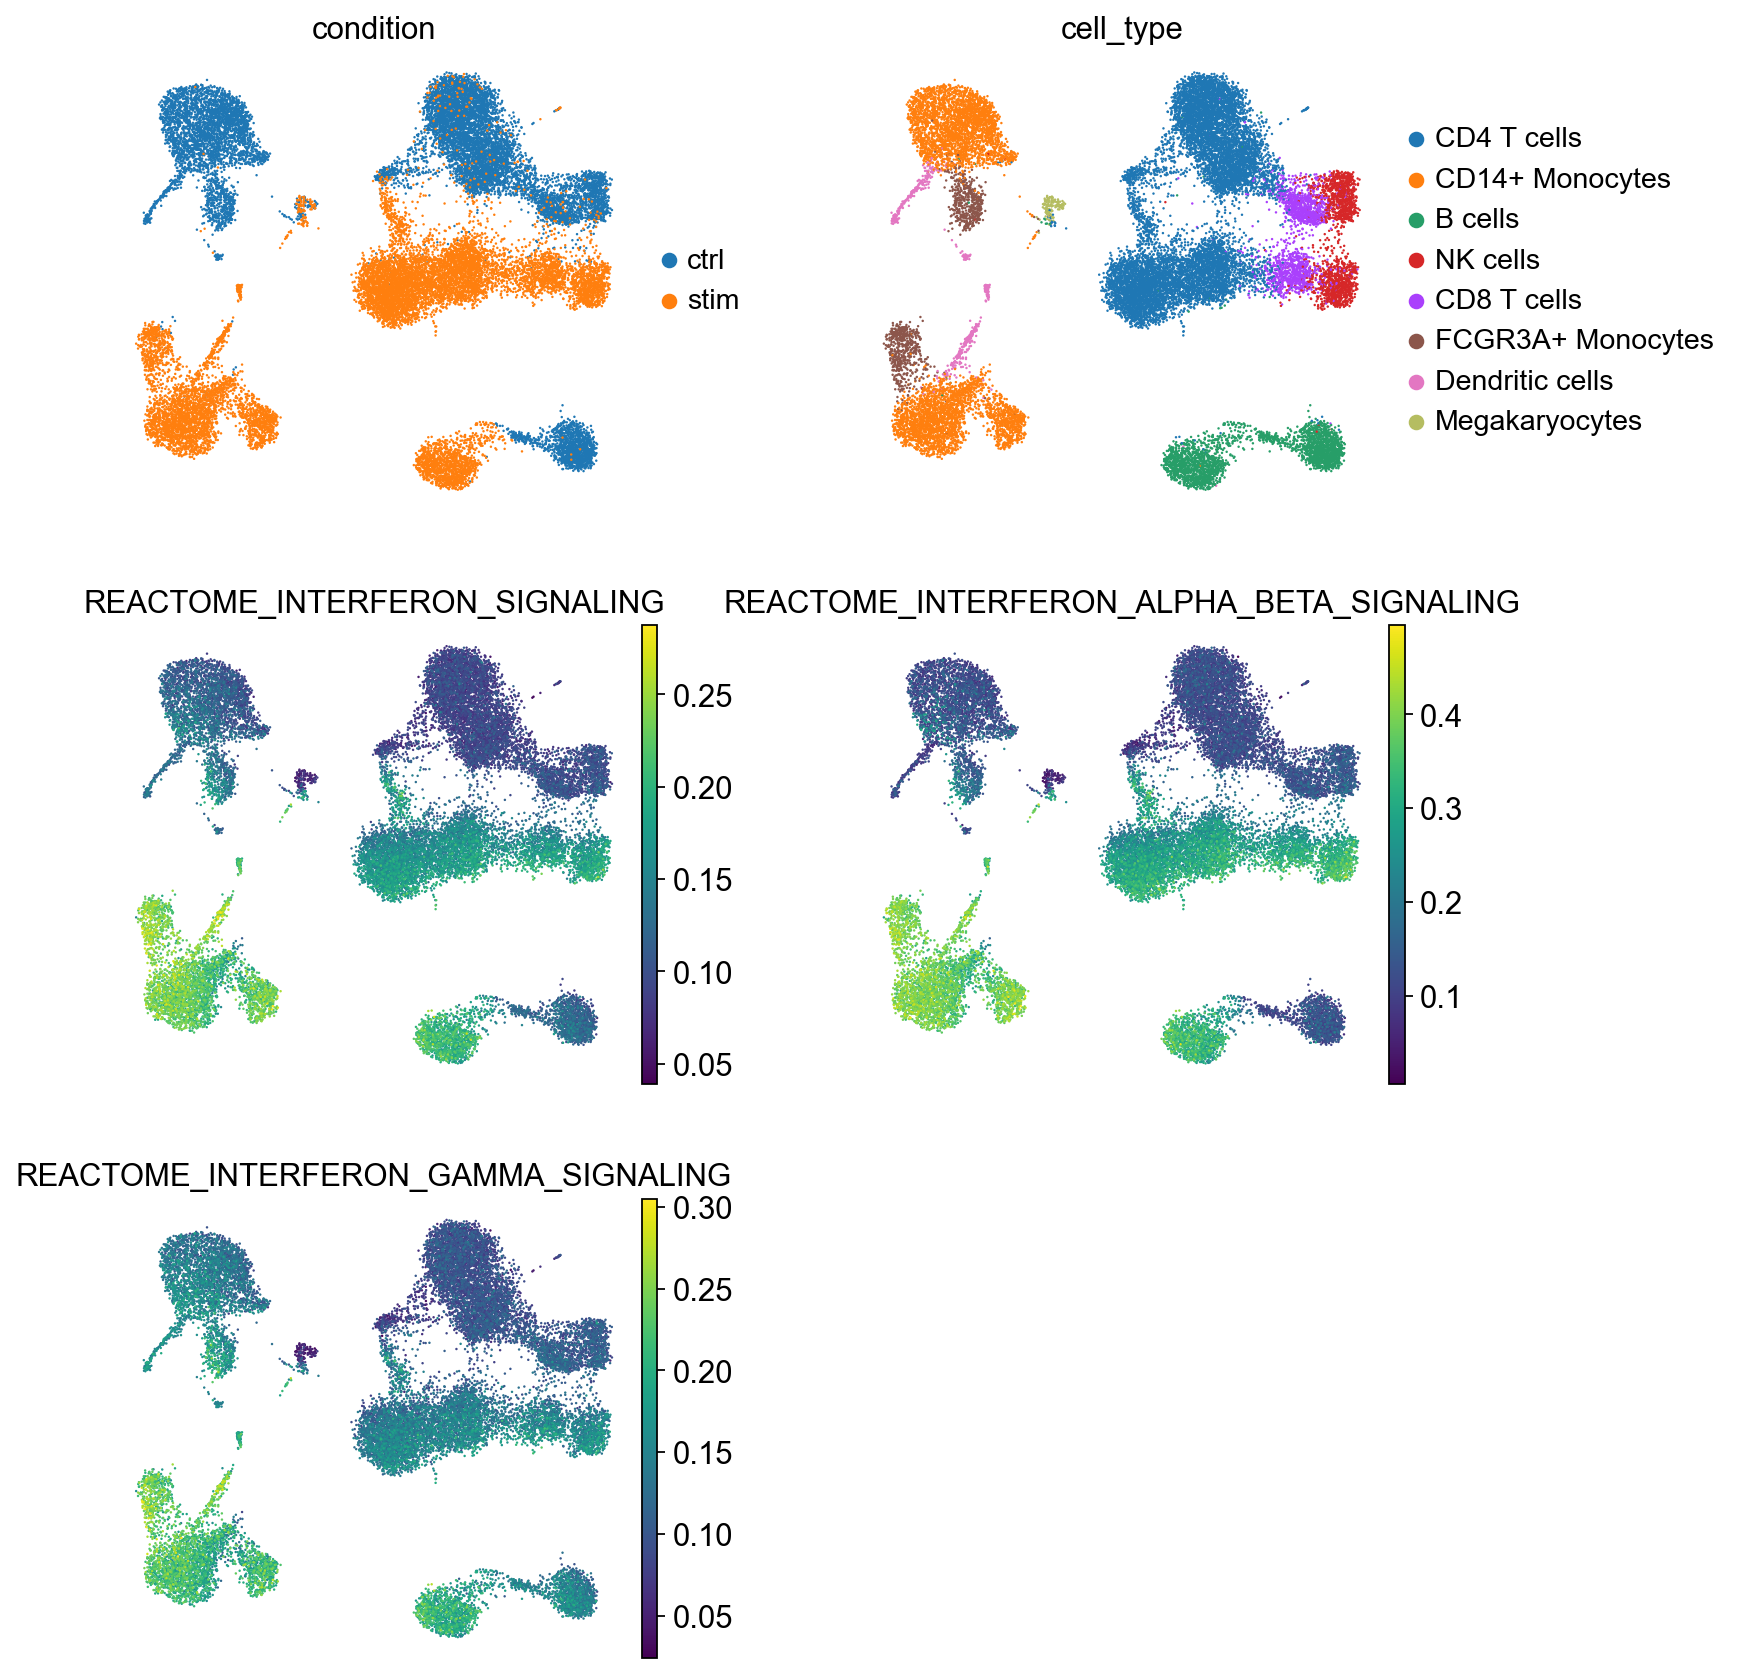

In [17]:
# Plot UMAP
sc.pl.umap(
    adata,
    color=["condition", "cell_type"] + ifn_pathways,
    frameon=False,
    ncols=2,
    wspace=0.3,
)

We can also visualize this as distributions in violinplots:

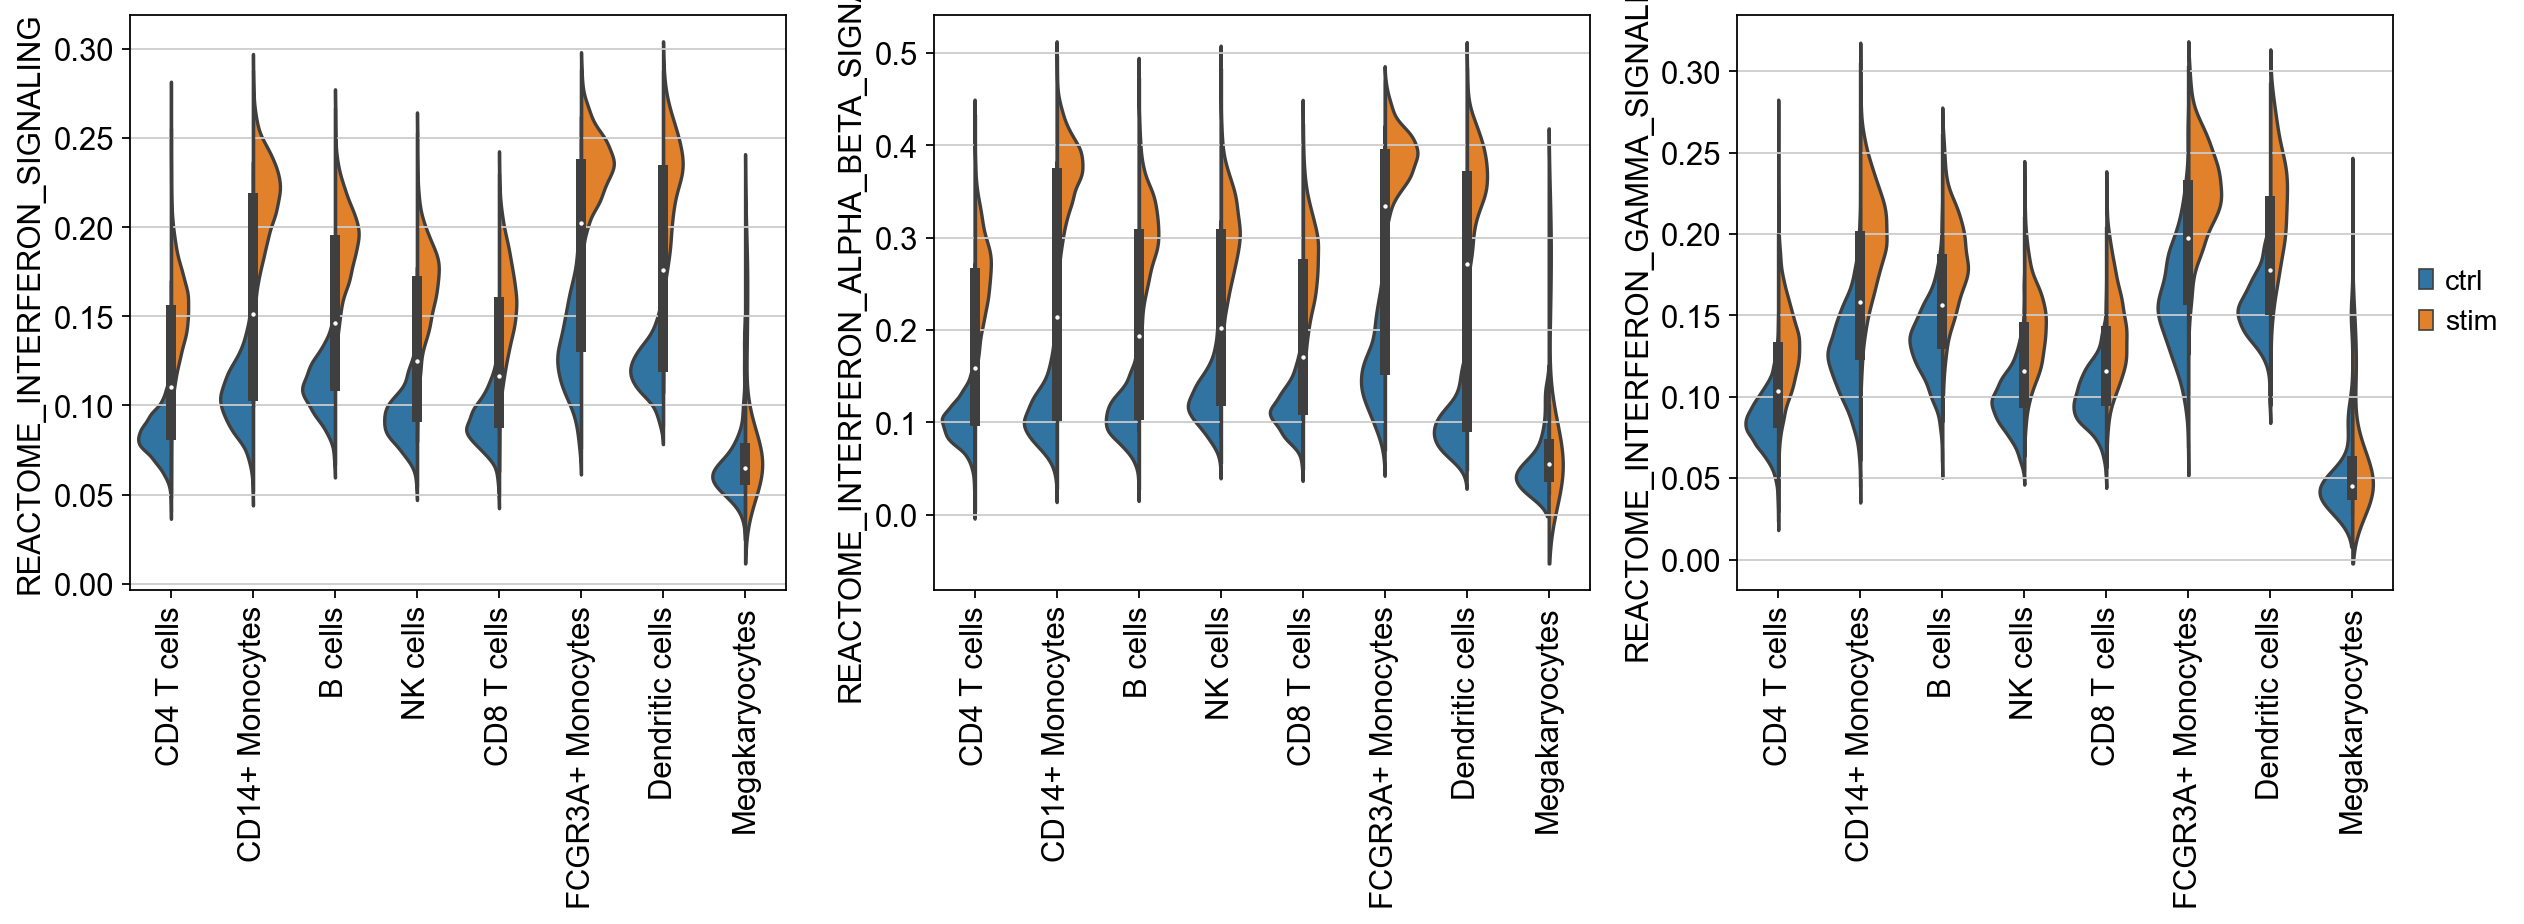

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)

for i, gset in enumerate(ifn_pathways):
    sns.violinplot(data=adata.obs,
                x="cell_type",
                y=gset,
                hue="condition",
                split=True,
                ax=axes[i]
               )
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].legend([], [], frameon=False)
    axes[i].set_xlabel('')
axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

AUCell scores the pathways well-known to be implicated in interferon signalling high in IFN-stimulated cells (except for Megakaryocytes which is expected), while cells in the control condition generally have lower scores for these pathways, demonstrating that gene set scoring with AUCell has been successful.

#### Inference using footprints with ULM

Additionally, we can infer pathway activities using footprints instead of gene sets. Here we will leverage the database PROGENy PROGENy {cite}`schubert2018perturbation`. Here is how to access it thorugh `decoupler`:

```python
# Retrieving via python
progeny = decoupler.get_progeny(organism='human', top=100)
```

However, again for stability of this tutorial we are using a fixed version.

Here we download and read the csv file for the PROGENy pathways:

In [19]:
if not Path("progeny.csv").is_file():
    !wget -O 'progeny.csv' https://figshare.com/ndownloader/files/38892066

progeny = pd.read_csv('progeny.csv')
progeny

source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.200000e-44
2     Androgen   MBOAT2  10.472733  4.600000e-44
3     Androgen     KLK2  10.176186  1.944410e-40
4     Androgen     SARG  11.386852  2.790210e-40
...        ...      ...        ...           ...
1395       p53  CCDC150  -3.174527  7.396252e-13
1396       p53    LCE1A   6.154823  8.475458e-13
1397       p53    TREM2   4.101937  9.739648e-13
1398       p53     GDF9   3.355741  1.087433e-12
1399       p53    NHLH2   2.201638  1.651582e-12

[1400 rows x 4 columns]

Note that in this resource, each gene has a weight associated to the pathway it belongs, denoting its mode of regulation (positive or negative) and its importance.

Now lets estimate pathway activities using ULM from `decoupler`, a method that accounts for weighted gene sets:

In [20]:
%%time
decoupler.run_ulm(
    mat=adata,
    net=progeny,
    source="source",
    target="target",
    weight="weight",
    use_raw=False,
)

adata

CPU times: user 2min 32s, sys: 308 ms, total: 2min 32s
Wall time: 22.1 s


AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'REACTOME_INTERFERON_SIGNALING', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', 'REACTOME_INTERFERON_GAMMA_SIGNALING'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'aucell_estimate', 'ulm_estimate', 'ulm_pvals'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Next we add the scores for the immune-related PROGENy pathways to the obs field of the AnnData object and annotate the activity level of these pathways in each of the cells on the UMAP:

In [21]:
imun_pathways = [
    "NFkB",
    "JAK-STAT",
    "TNFa"
]

adata.obs[imun_pathways] = adata.obsm["ulm_estimate"][imun_pathways]

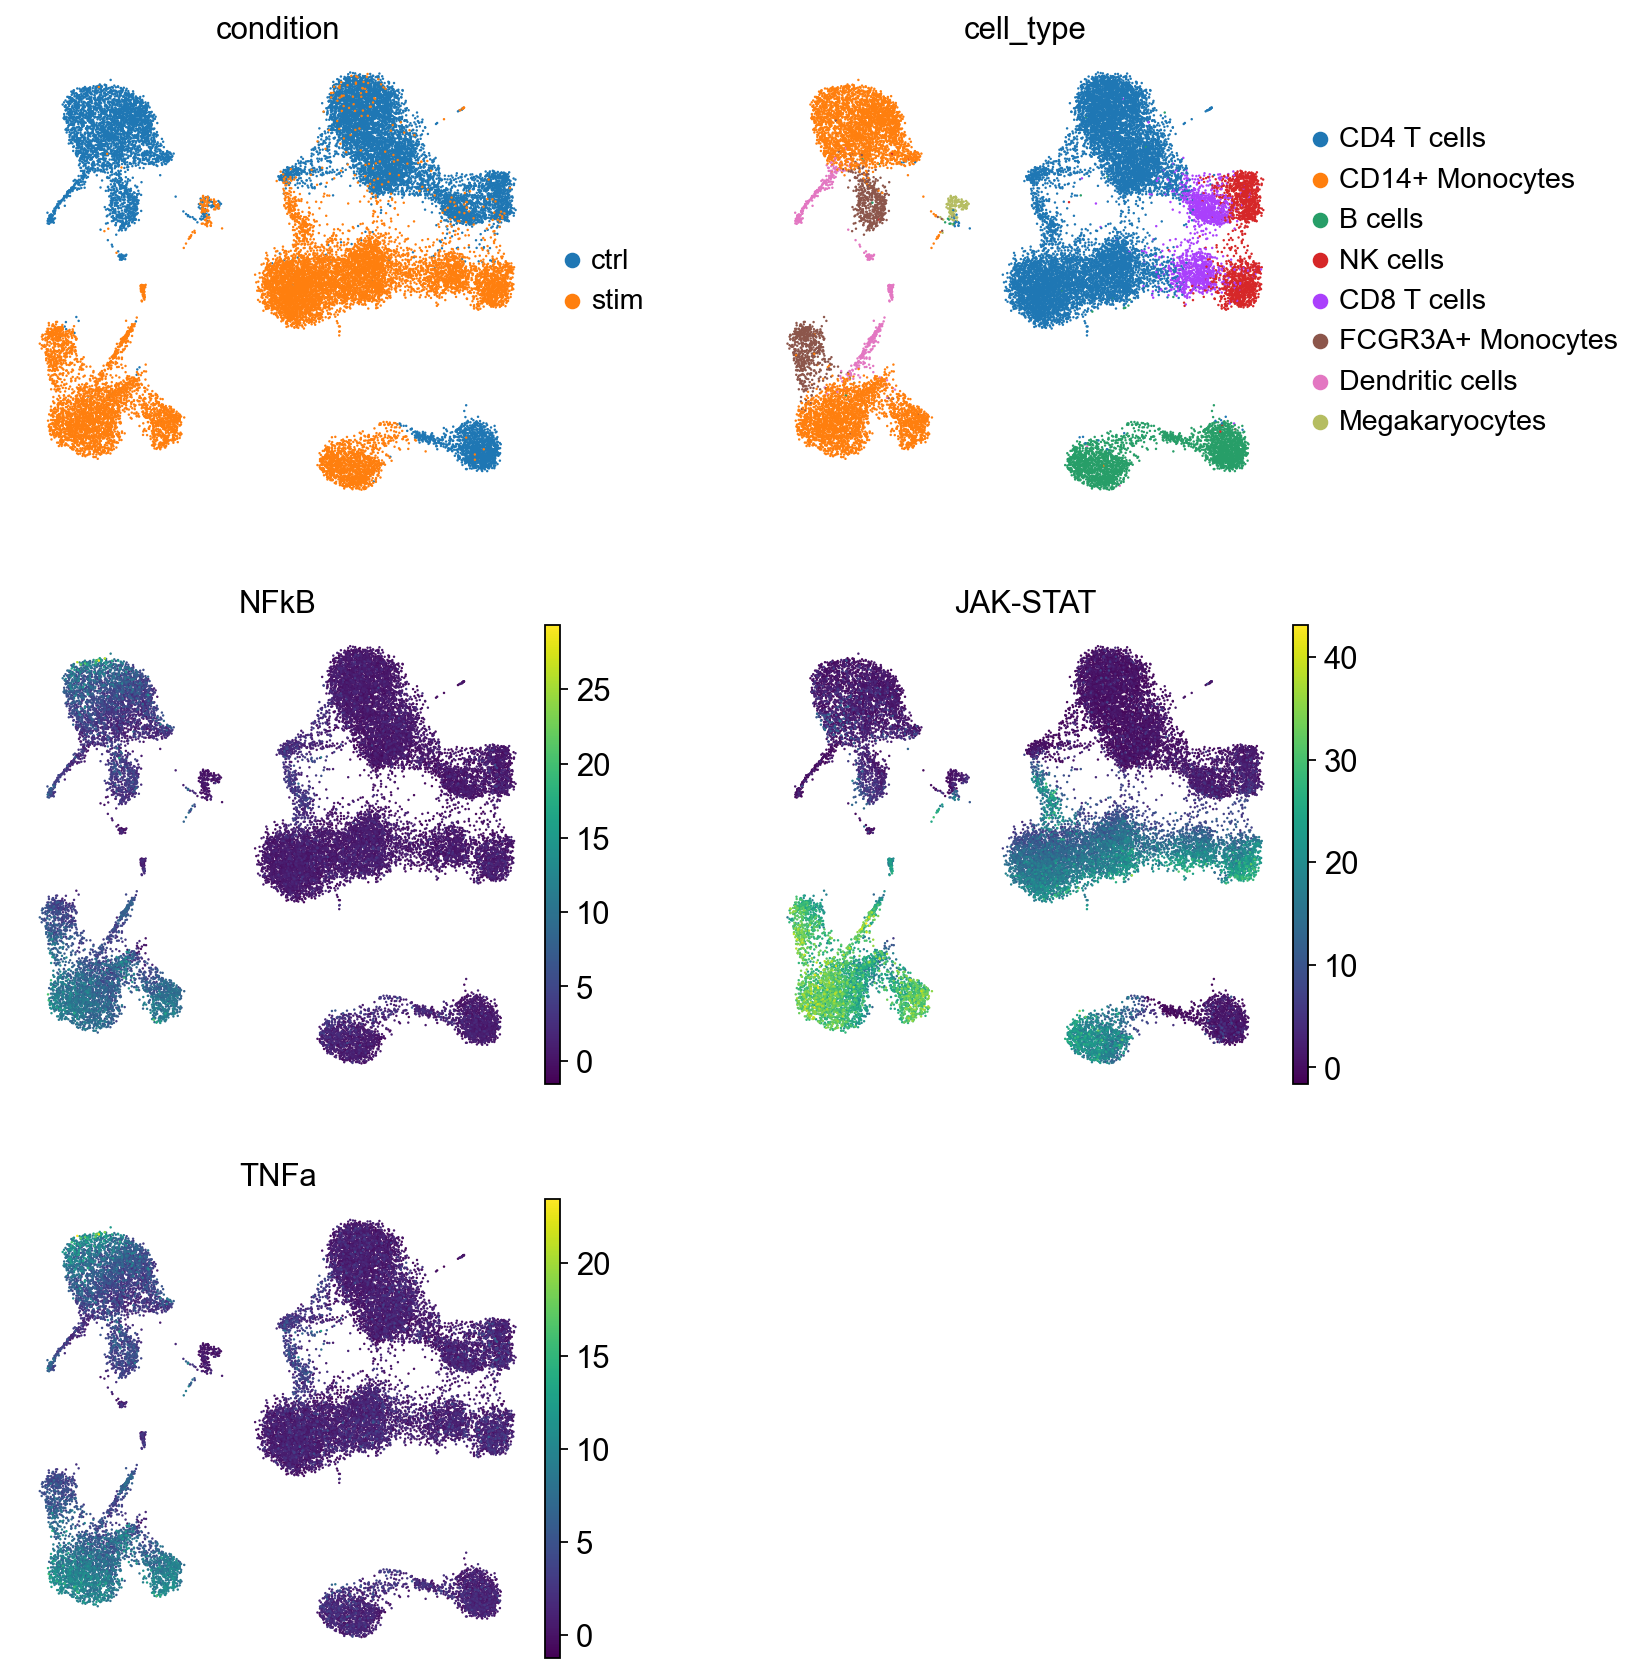

In [22]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"] + imun_pathways,
    frameon=False,
    ncols=2,
    wspace=0.3,
)

As before, we can also visualize this in violinplots:

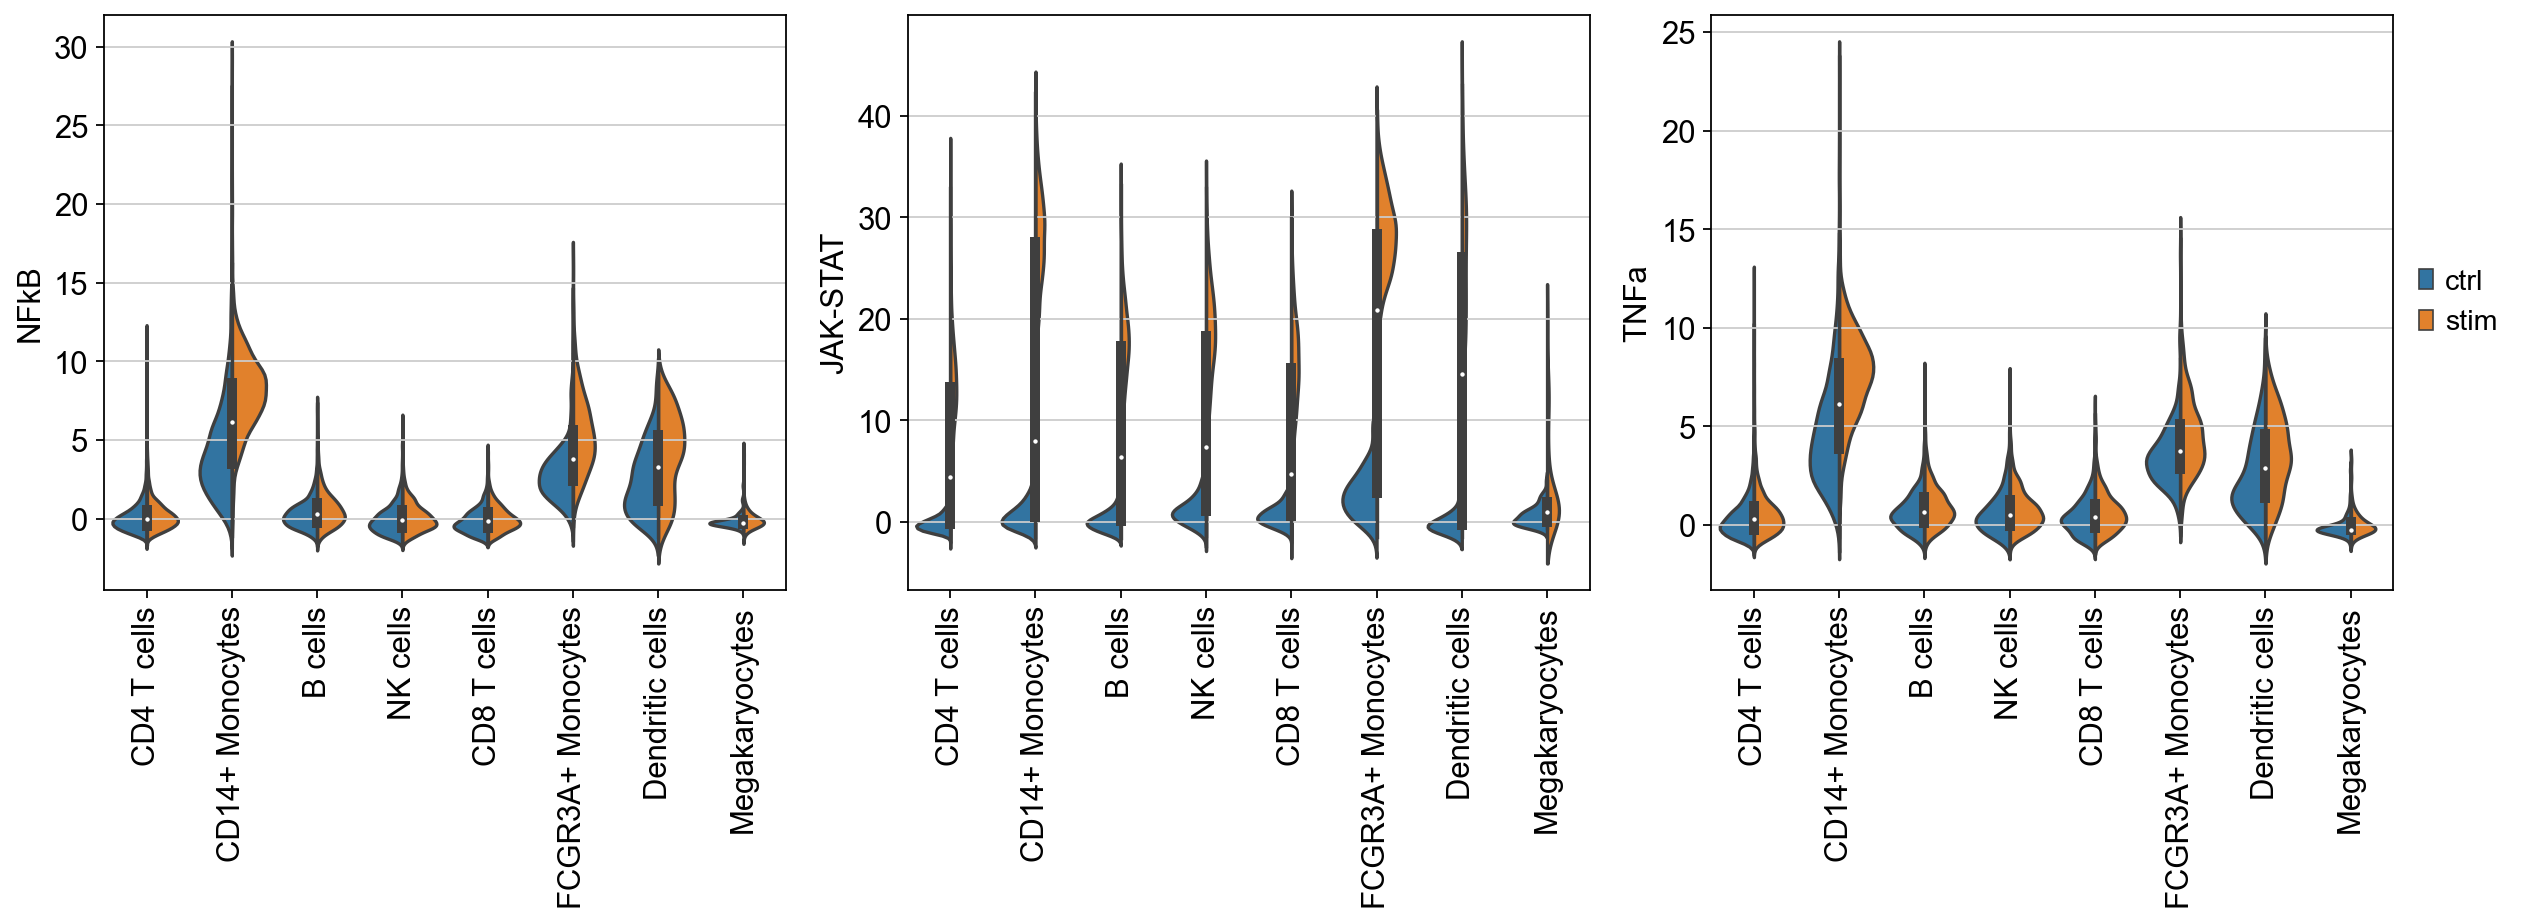

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)

for i, gset in enumerate(imun_pathways):
    sns.violinplot(data=adata.obs,
                x="cell_type",
                y=gset,
                hue="condition",
                split=True,
                ax=axes[i]
               )
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].legend([], [], frameon=False)
    axes[i].set_xlabel('')
axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

In this case, the pathway JAK-STAT, triggered by the binding of interferons such as INF-beta, is the most active one after stimulation. The other immune pathways, NFkB and TNFa, remain overall the same. The concordance between pathway activity scores by AUCell and ULM is promising, given that we know a priori that IFN-related pathways should be the top-ranked terms.

### Population contrast enrichment scoring

Previously we have enriched functional terms for each individual cell, now we will do it between populations. We will first pseudobulk our samples and cell type combinations to generate richer profiles, and perform differential testing on those to mitigate inflated p-values {cite}`squair2021psbulk`. For this example we will use a simple t-test without correcting for other covariates such as sex, age or others. For best practices and more complex testing strategies check the [Differential gene expression analysis](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) chapter.

#### Pseudobulking and differential gene testing

We can pseudobulk from the raw counts (stored in `adata.layers['counts']`) using `decoupler`. Note that the parameter `min_prop` will filter out lowly expressed genes.

In [24]:
# Create unique ids for each patient and condition
adata.obs['sample_id'] = adata.obs['condition'].astype(str) + '|' + adata.obs['replicate'].astype(str)

# Pseudobulk
pdata = decoupler.get_pseudobulk(
    adata,
    sample_col='sample_id',
    groups_col='cell_type',
    use_raw=False,
    layer='counts',
    min_prop=0.2,
    min_smpls=3
)

pdata

View of AnnData object with n_obs × n_vars = 108 × 2435
    obs: 'condition', 'cell_type', 'replicate', 'sample_id'

The obtained object contains one transcriptomic profile per sample and cell type combination. Then we normalize the obtained summarized counts:

In [25]:
# Storing the raw counts
pdata.layers["counts"] = pdata.X.copy()

# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)

# Normalize
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

We can explored the obtained profiles by performing PCA. We will not use a neighbor embedding here since the sample size is significantly reduced.

In [26]:
sc.pp.pca(pdata)

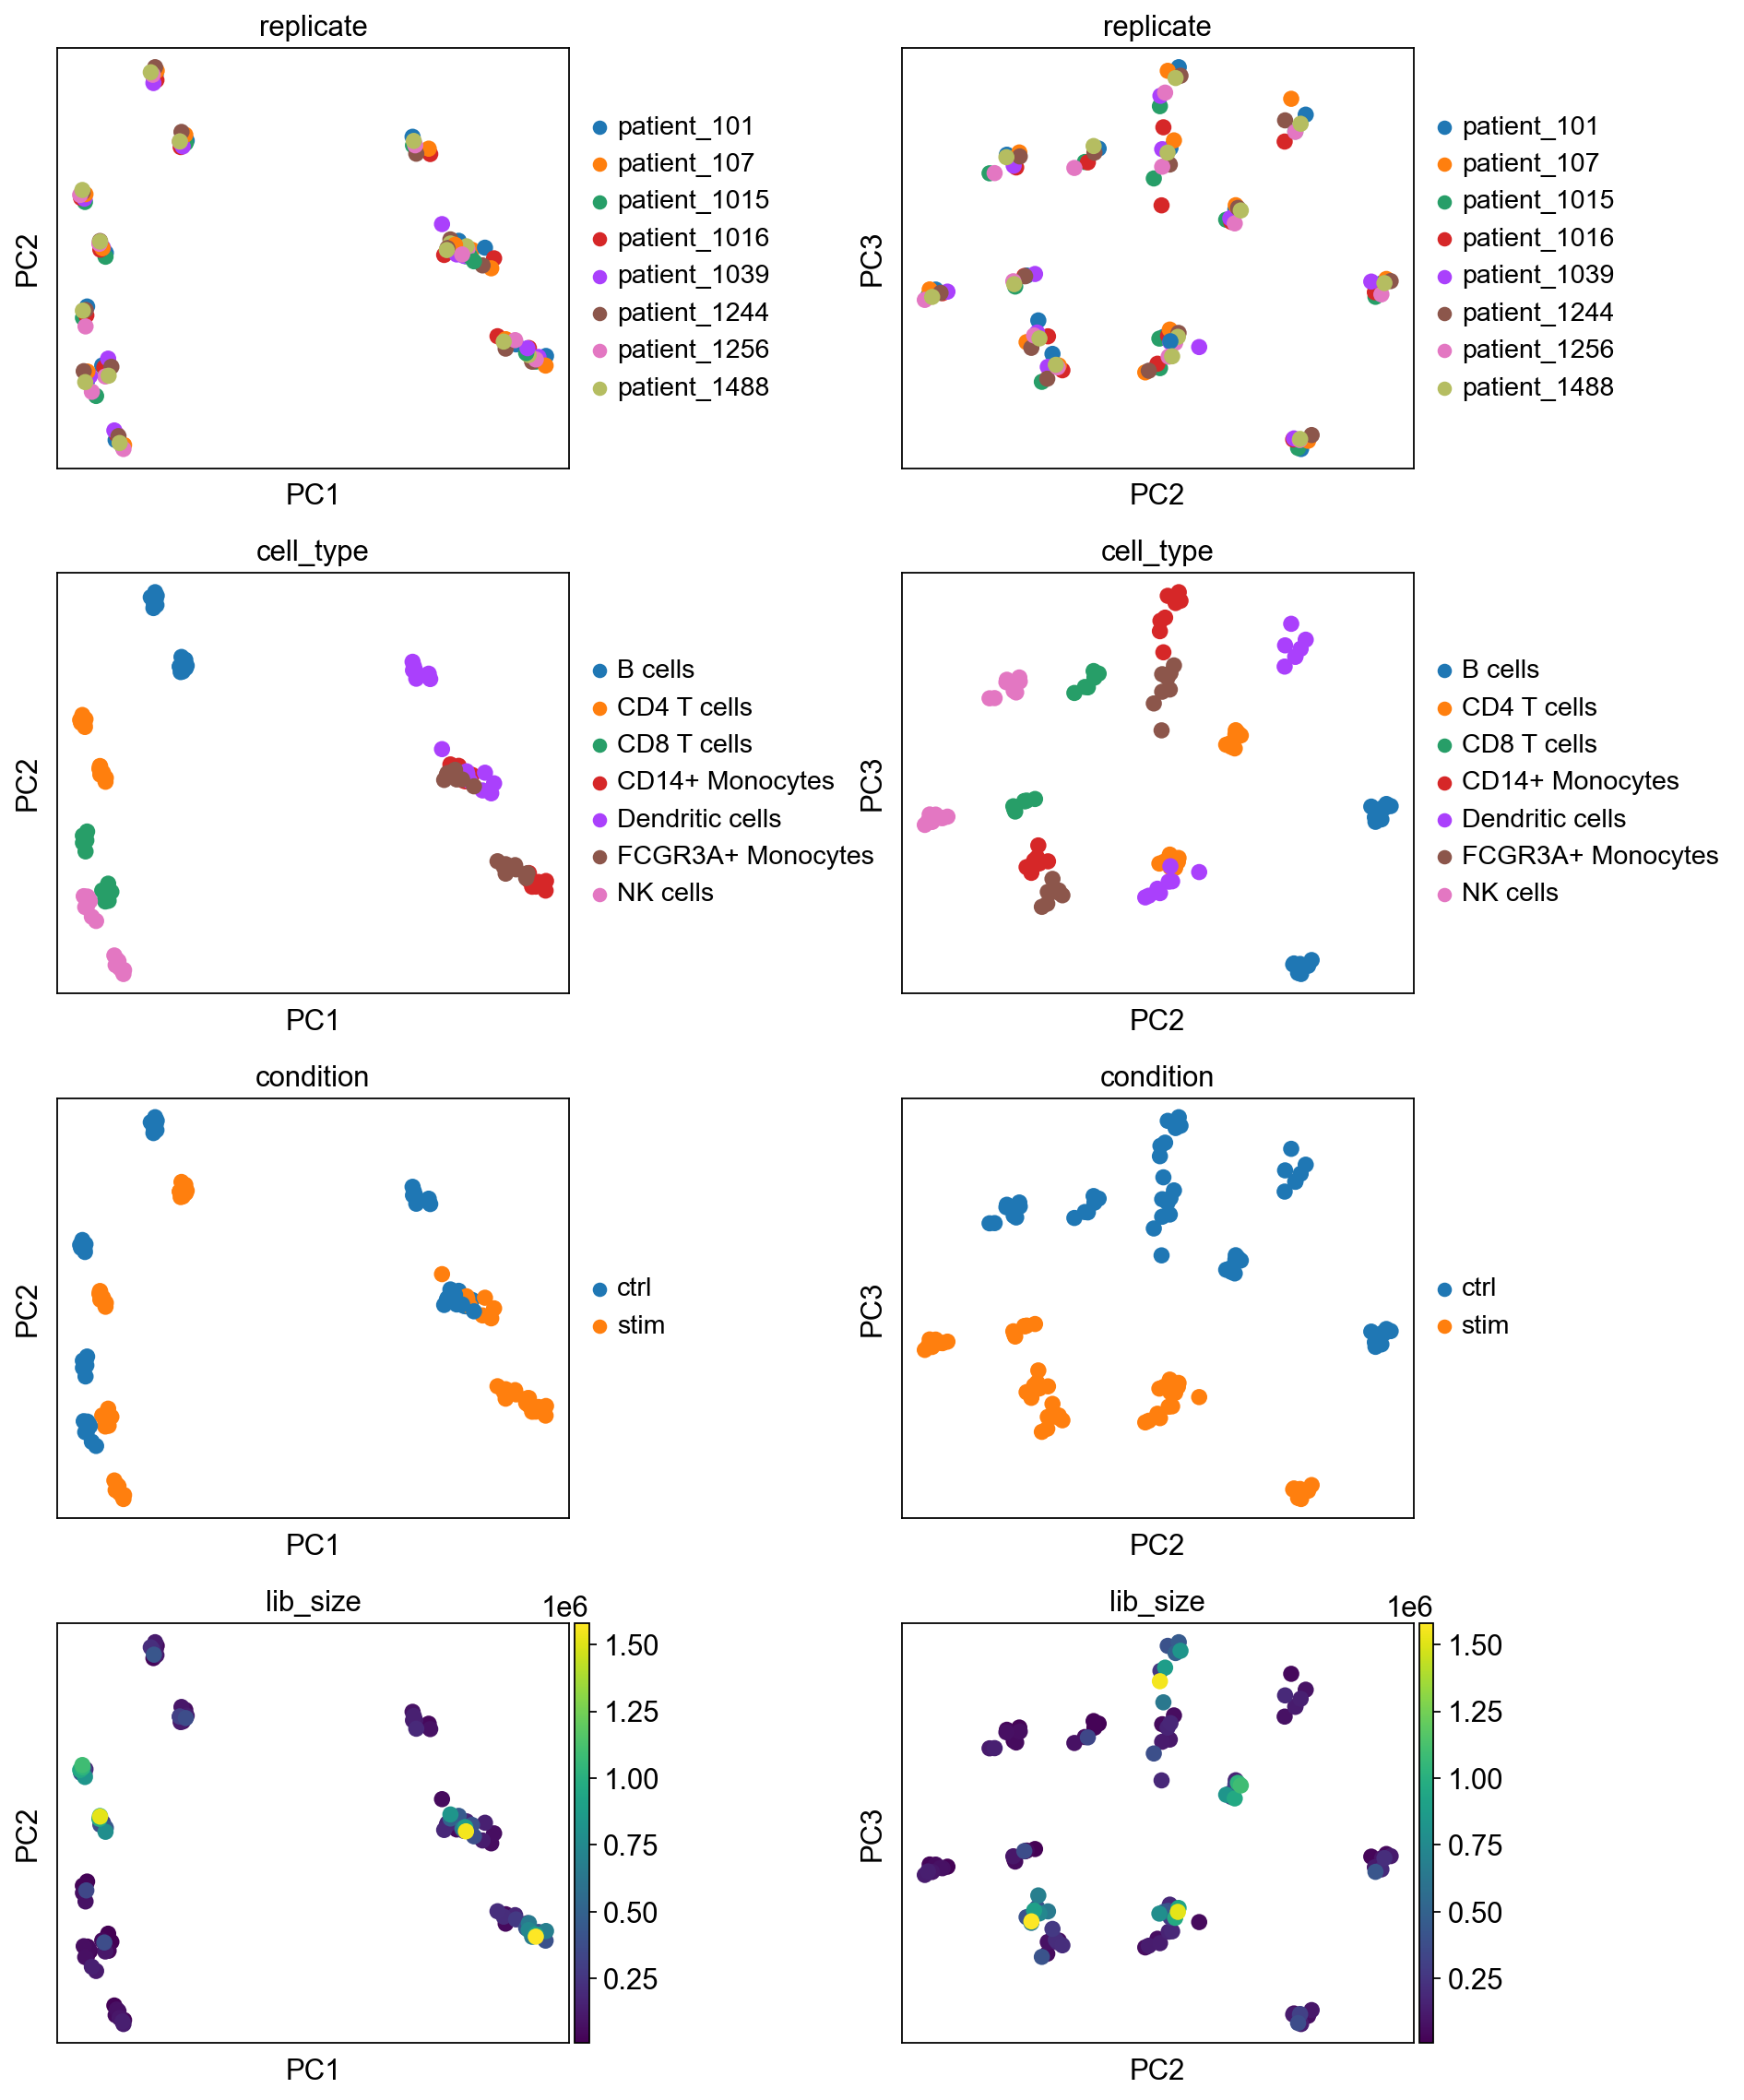

In [27]:
# Plot first 3 PCs
sc.pl.pca(
    pdata,
    color=["replicate", "cell_type", "condition", "lib_size"],
    ncols=2,
    size=250,
    components=['1,2', '2,3'],
    wspace=0.5
)

PC1 now captures difference between lymphoid (T, NK, B) and myeloid (Mono, DC) populations, while the third PC captures variation due to administration of stimulus (i.e. difference between control and stimulated pseduo-replicates). Ideally, the variation of interest has to be detectable in top few PCs of the pseudobulk data.

In this case, since we are indeed interested in stimulation effect per cell type, we proceed to gene set testing. We re-iterate that the purpose of plotting PCs is to explore various axes of variability in the data and to spot unwanted variability that can substantial influence the test results. Users may proceed with the rest of the analyses should they be satisfied with the the variations in their data.

Here we perform a simple t-test per cell type to obtain gene statistics:

In [28]:
logFCs, pvals = decoupler.get_contrast(pdata,
                                group_col='cell_type',
                                condition_col='condition',
                                condition='stim',
                                reference='ctrl',
                                method='t-test'
                               )
logFCs

AAED1      AAMP    ABHD12     ABHD3      ABI1      ABI3  \
B cells            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CD14+ Monocytes    0.890117  0.000000  0.000000  0.000000  0.000000  0.000000   
CD4 T cells        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CD8 T cells        0.000000  0.000000  0.000000  0.000000  0.000000 -0.301946   
Dendritic cells    0.634967 -0.608719  0.112235  0.000000  0.017562 -0.809987   
FCGR3A+ Monocytes  0.000000  0.000000  0.000000  0.066368  0.814601 -0.771369   
NK cells           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                     ABRACL      ABT1     ACAA1     ACAA2  ...    ZNF259  \
B cells            0.000000  0.000000  0.000000  0.000000  ...  0.000000   
CD14+ Monocytes    0.480055  0.000000  0.000000  0.000000  ...  0.000000   
CD4 T cells        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
CD8 T cells        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Dendritic cells    0.394191 -0.502891  0.000000  0.000000  ... -0.980746   
FCGR3A+ Monocytes -0.206976  0.000000 -2.153326 -0.421191  ...  0.000000   
NK cells           0.000000  0.000000  0.000000  0.000000  ...  0.000000   

                     ZNF267    ZNF277    ZNF655    ZNF706     ZNFX1    ZNHIT1  \
B cells            0.000000  0.000000  0.000000 -0.459978  0.000000  0.000000   
CD14+ Monocytes    0.000000  0.000000  0.000000  0.062595  1.870545 -1.665710   
CD4 T cells        0.000000  0.000000  0.000000 -0.120450  0.000000  0.000000   
CD8 T cells        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Dendritic cells   -0.171504  0.000000 -0.323885 -0.017189  1.621633 -0.745664   
FCGR3A+ Monocytes  0.000000  1.423819  0.000000 -0.022550  2.459813 -0.686029   
NK cells           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      ZNRD1    ZRANB2       ZYX  
B cells            0.000000  0.000000  0.000000  
CD14+ Monocytes    0.000000  0.000000  0.000000  
CD4 T cells        0.000000  0.000000  0.000000  
CD8 T cells        0.000000  0.000000  0.000000  
Dendritic cells    0.000000  0.100415 -1.111114  
FCGR3A+ Monocytes -0.812469  0.000000 -0.593690  
NK cells           0.000000  0.000000  0.000000  

[7 rows x 2435 columns]

We can visualize the obtained contrast for CD16 (FCGR3A+) Monocytes:

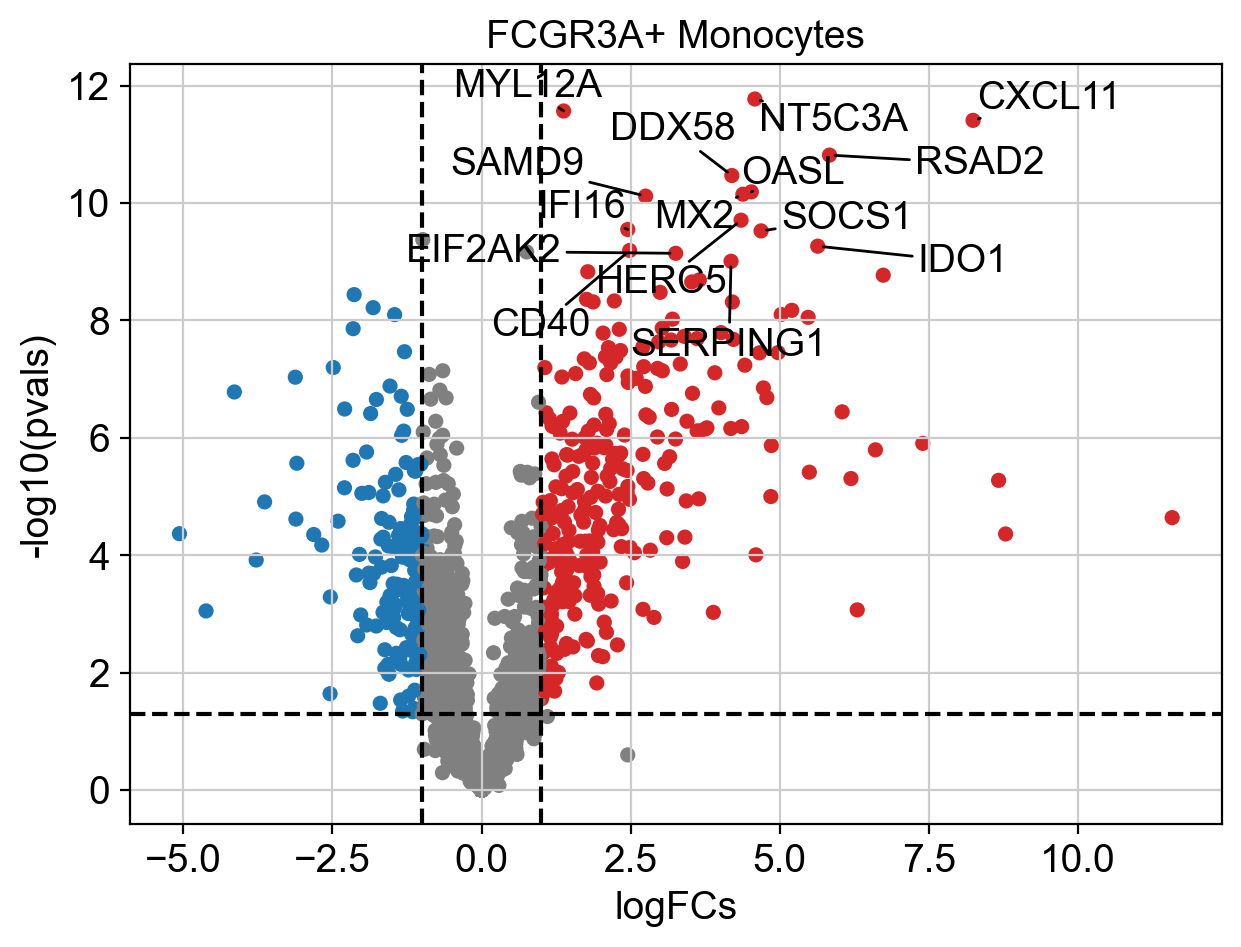

In [29]:
decoupler.plot_volcano(logFCs, pvals, 'FCGR3A+ Monocytes', top=15, sign_thr=0.05, lFCs_thr=1)

In [30]:
deg = decoupler.format_contrast_results(logFCs, pvals)
deg[np.isin(deg["contrast"], 'FCGR3A+ Monocytes')].head()

contrast    name    logFCs         pvals adj_pvals
12175  FCGR3A+ Monocytes  NT5C3A  4.582433  1.682674e-12       0.0
12176  FCGR3A+ Monocytes  MYL12A  1.376481  2.694144e-12       0.0
12177  FCGR3A+ Monocytes  CXCL11  8.240464  3.892215e-12       0.0
12178  FCGR3A+ Monocytes   RSAD2  5.834089  1.520403e-11       0.0
12179  FCGR3A+ Monocytes   DDX58  4.196766  3.388842e-11       0.0

#### Inference using gene sets with GSEA

Once we obtained gene statistics from the contrast, we will use those to infer pathway activities using GSEA {cite}`subramanian2005gene` from `decoupler`.

In [31]:
# Infer pathway activities with gsea
scores, norm, pvals = decoupler.run_gsea(
    mat=logFCs.loc[['FCGR3A+ Monocytes']],
    net=reactome
)

# Format results
gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pvals": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pvals")
)

gsea_results.head()

score      norm  \
source                                                                   
REACTOME_INTERFERON_SIGNALING                       0.734492  5.689662   
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING            0.819318  4.872475   
REACTOME_TRANSLATION                               -0.446647 -4.401173   
REACTOME_EUKARYOTIC_TRANSLATION_INITIATION         -0.490272 -4.265938   
REACTOME_THE_CITRIC_ACID_TCA_CYCLE_AND_RESPIRAT... -0.555797 -4.151557   

                                                           pvals  
source                                                            
REACTOME_INTERFERON_SIGNALING                       1.272907e-08  
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING            1.102087e-06  
REACTOME_TRANSLATION                                1.076674e-05  
REACTOME_EUKARYOTIC_TRANSLATION_INITIATION          1.990638e-05  
REACTOME_THE_CITRIC_ACID_TCA_CYCLE_AND_RESPIRAT...  3.302204e-05

In the cell above, pvals is the p-value for the enrichment test, while score and norm are the enrichment scores and the z-scored enrichment scores obtained after performing permutations, respectively. Note that enrichment scores are signed. Therefore, a negative scores suggests the pathway is down-regulated and a positive score is indicative of up-regulation of genes in the pathway or gene set. Let us plot the top ranked pathways:

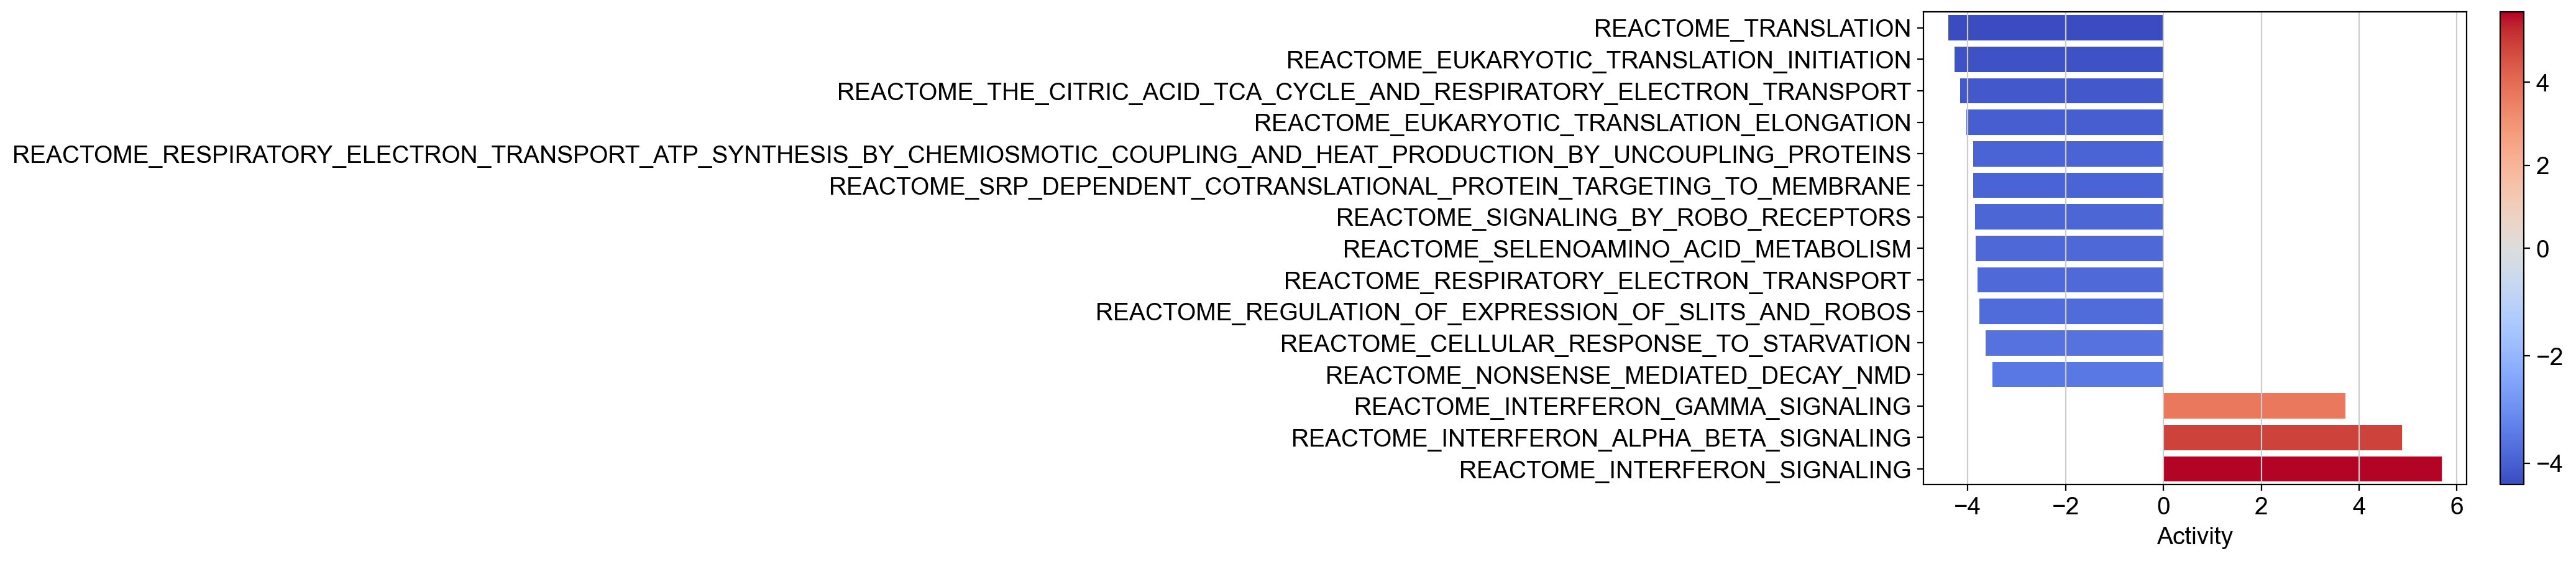

In [32]:
decoupler.plot_barplot(norm, 'FCGR3A+ Monocytes', top=15, vertical=True)

In the plot above, pathway names are given in the y-axis. The x-axis describes the z-scored enrichment score of the GSEA test compared to a random background distribution, more absolute value activity means more significance in the enrichment. Only the top 15 pathways are shown, and are ordered by directionality and significance. The majority of interferon-related pathways are indeed positively ranked and in the right direction.

#### Inference using footprints with ULM
Let us leverage the contrast statistics again, but this time with the PROGENy footprints and the ULM method.

In [33]:
# Infer pathway activities with ulm
scores, pvals = decoupler.run_ulm(
    mat=logFCs.loc[['FCGR3A+ Monocytes']],
    net=progeny
)

# Format results
ulm_results = (
    pd.concat({"score": scores.T, "pvals": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pvals")
)

ulm_results

score         pvals
JAK-STAT  20.498243  3.950257e-83
NFkB       3.231741  1.255336e-03
TNFa       1.778404  7.552673e-02
PI3K      -0.920369  3.575181e-01
EGFR      -0.736374  4.616106e-01
p53       -0.479213  6.318526e-01
Hypoxia    0.183501  8.544278e-01
MAPK      -0.175678  8.605692e-01

In the cell above, pvals is the p-value for the enrichment test, while the score is the statistic from the ULM method. Like in GSEA, enrichment scores are signed. Let us plot the 14 pathways available in PROGENy:

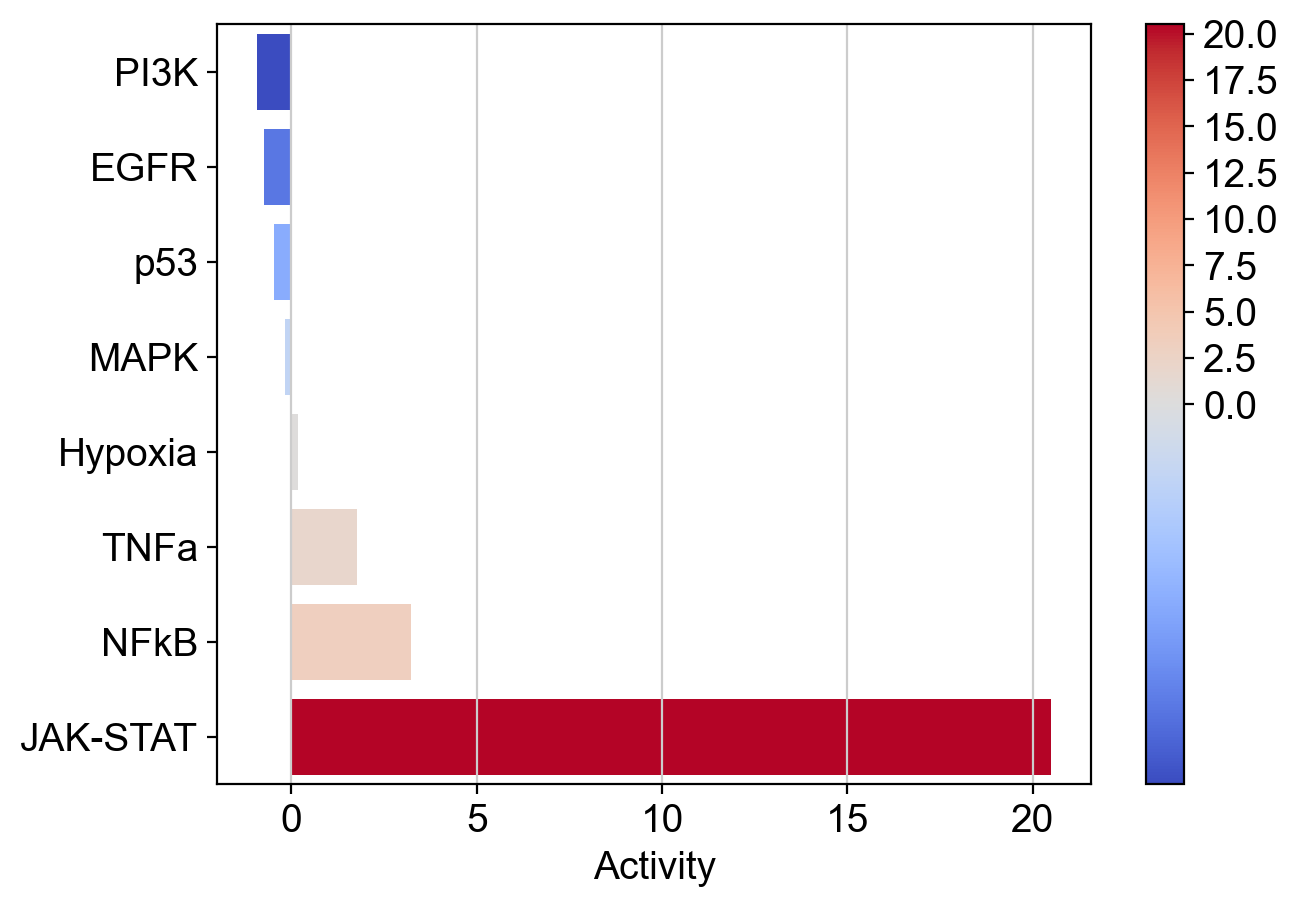

In [34]:
decoupler.plot_barplot(scores, 'FCGR3A+ Monocytes', top=15, vertical=True)

As seen in the previous section, JAK-STAT, a INF-beta induced pathway, is the most active pathway in stimulated CD16 Monocytes compared to the control ones.

#### Inference using gene sets with fry

Finally, we will perform enrichment using the `fry` method from the [BioConductor](https://www.bioconductor.org/) package `limma`. `fry` performs its own differential testing so we will need to set up design and contrast matrices. Let us remind ourselves that a design matrix is a mathematical representation of group membership (i.e. the group or condition to which a sample belongs), and contrast matrices are mathematical representations of comparisons of interest for the differential test.

In [35]:
groups = pdata.obs.condition.astype(str) + "_" + pdata.obs.cell_type.astype(str)

In [36]:
%%R -i groups
group <-  as.factor(gsub(" |\\+","_", groups))
design <- model.matrix(~ 0 + group)
head(design)

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0
[2,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0
[3,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0
[4,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0
[5,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0
[6,]    1    0    0    0    0    0    0    0    0     0     0     0     0     0


In [37]:
%%R
colnames(design)

 [1] "groupctrl_B_cells"           "groupctrl_CD14__Monocytes"  
 [3] "groupctrl_CD4_T_cells"       "groupctrl_CD8_T_cells"      
 [5] "groupctrl_Dendritic_cells"   "groupctrl_FCGR3A__Monocytes"
 [7] "groupctrl_NK_cells"          "groupstim_B_cells"          
 [9] "groupstim_CD14__Monocytes"   "groupstim_CD4_T_cells"      
[11] "groupstim_CD8_T_cells"       "groupstim_Dendritic_cells"  
[13] "groupstim_FCGR3A__Monocytes" "groupstim_NK_cells"         


In [38]:
%%R 
kang_pbmc_con <- limma::makeContrasts(
    
    # the effect if stimulus in CD16 Monocyte cells
    groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes,
    
    # the effect of stimulus in CD16 Monocytes compared to CD8 T Cells
    (groupstim_FCGR3A__Monocytes - groupctrl_FCGR3A__Monocytes) - (groupstim_CD8_T_cells - groupctrl_CD8_T_cells), 
    levels = design
)

Index the genes annotated in each pathway in our data as follows:

In [39]:
log_norm_X = pdata.to_df().T

In [40]:
%%R -i log_norm_X -i reactome
# Move pathway info from python to R
pathways = split(reactome$target, reactome$source)
# Map gene names to indices
idx = limma::ids2indices(pathways, rownames(log_norm_X))

/home/badi/miniconda3/envs/pathway/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/badi/miniconda3/envs/pathway/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


Now that we have set up the design and contrast matrices, and have indexed the genes in each pathway in our data, we can call `fry()` to test for enriched pathways in each of the contrasts we set above:

In [41]:
%%R -o fry_results
fry_results <- limma::fry(log_norm_X, index = idx, design = design, contrast = kang_pbmc_con[,1])

Taking a look at the top ranked pathways we’ll see some familiar names:

In [42]:
fry_results.head()

NGenes Direction  \
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING                43        Up   
REACTOME_NICOTINATE_METABOLISM                           6        Up   
REACTOME_DEFECTS_OF_CONTACT_ACTIVATION_SYSTEM_C...       1        Up   
REACTOME_TRAF6_MEDIATED_IRF7_ACTIVATION                  5        Up   
REACTOME_INTERFERON_SIGNALING                           96        Up   

                                                          PValue  \
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING            4.887280e-48   
REACTOME_NICOTINATE_METABOLISM                      8.032772e-46   
REACTOME_DEFECTS_OF_CONTACT_ACTIVATION_SYSTEM_C...  3.806314e-45   
REACTOME_TRAF6_MEDIATED_IRF7_ACTIVATION             1.212377e-42   
REACTOME_INTERFERON_SIGNALING                       5.470216e-41   

                                                             FDR  \
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING            4.672240e-45   
REACTOME_NICOTINATE_METABOLISM                      3.839665e-43   
REACTOME_DEFECTS_OF_CONTACT_ACTIVATION_SYSTEM_C...  1.212945e-42   
REACTOME_TRAF6_MEDIATED_IRF7_ACTIVATION             2.897580e-40   
REACTOME_INTERFERON_SIGNALING                       1.045905e-38   

                                                    PValue.Mixed     FDR.Mixed  
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING            2.026841e-33  2.279600e-32  
REACTOME_NICOTINATE_METABOLISM                      4.805737e-04  1.324001e-03  
REACTOME_DEFECTS_OF_CONTACT_ACTIVATION_SYSTEM_C...  3.806314e-45  6.616065e-44  
REACTOME_TRAF6_MEDIATED_IRF7_ACTIVATION             3.465721e-03  8.765156e-03  
REACTOME_INTERFERON_SIGNALING                       2.705805e-91  1.361447e-89

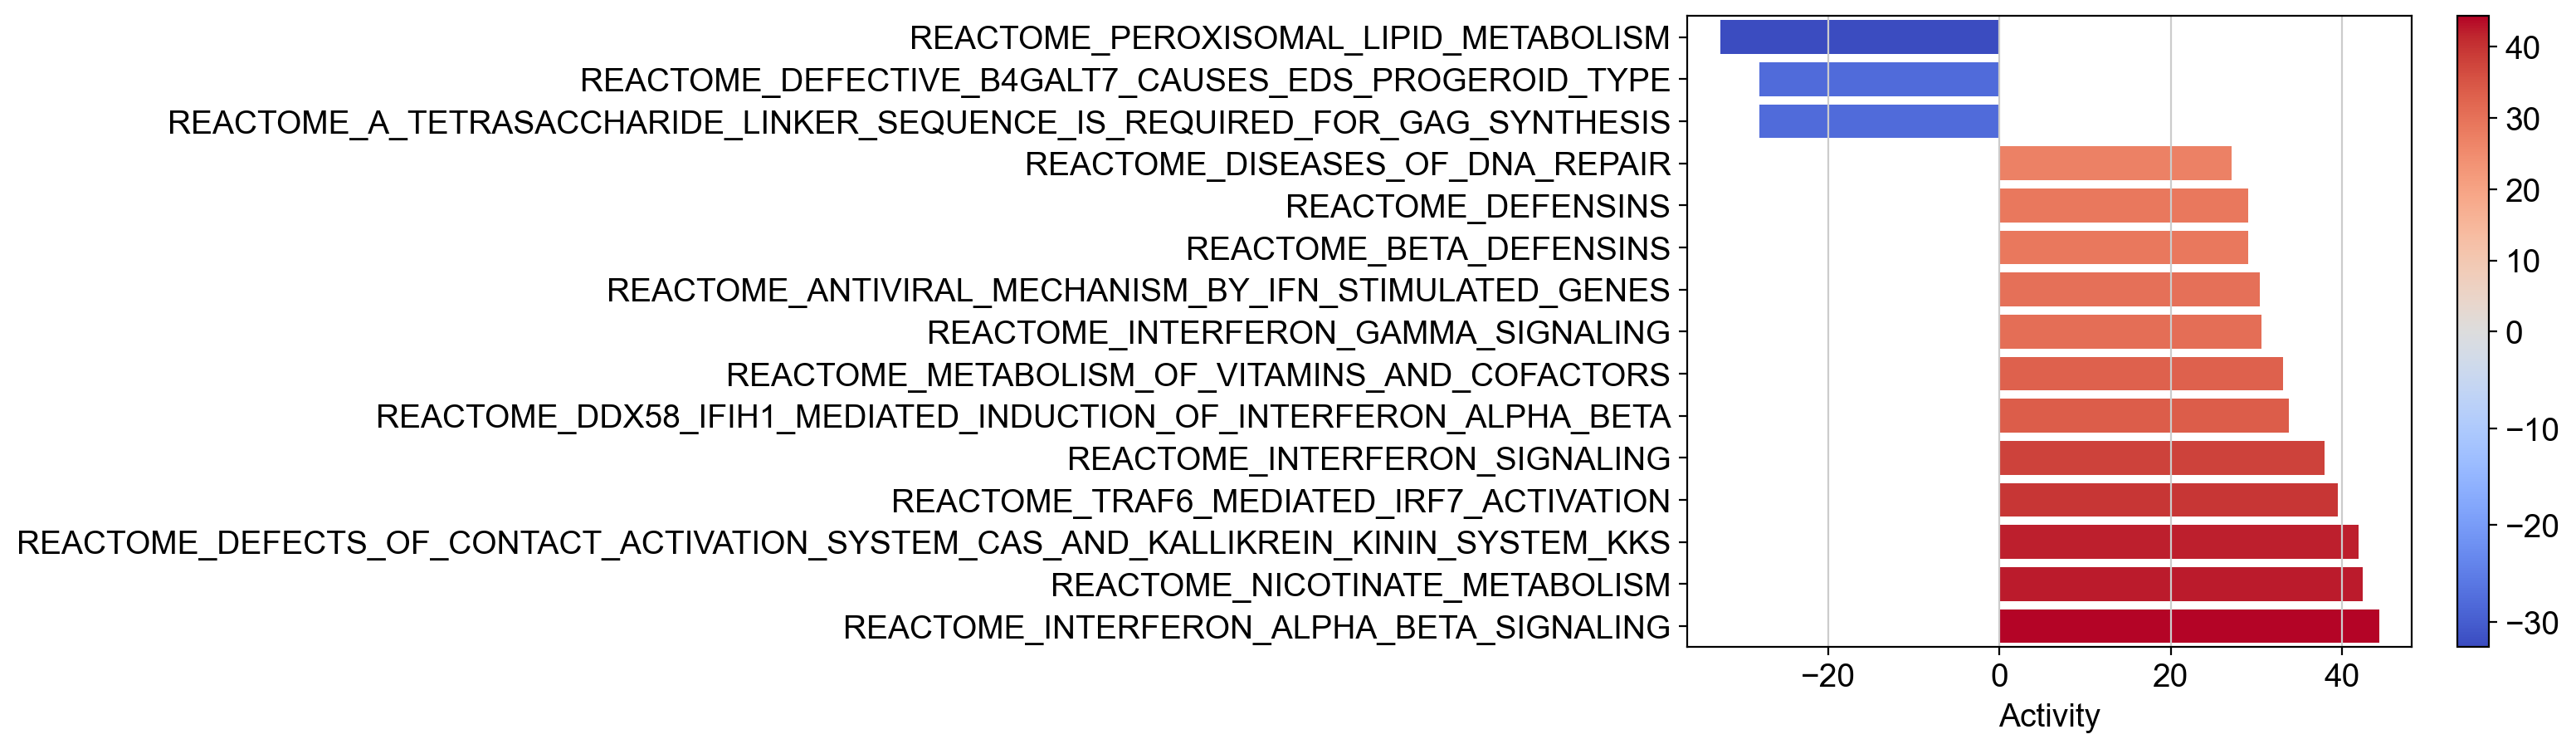

In [43]:
# Format obtained pvalues into score
fry_results['sign'] = -1
fry_results.loc[fry_results['Direction'].astype(str) == 'Up', 'sign'] = 1
fry_results['score'] = -np.log10(fry_results['FDR']) * fry_results['sign']

decoupler.plot_barplot(
    fry_results[['score']].T,
    'score',
    top=15,
    vertical=True
)

In the plot above, the x-axis describes the directed `-log10(FDR)` obtained by running the `fry` method, more absolute value activity means more significance in the enrichment. Only the top 15 pathways are shown, and are ordered by directionality and significance. The majority of interferon-related pathways are indeed positively ranked and in the right direction. As seen before, some IFN-related pathways seem to be positively enriched.

For this example we were interested in cell type specific responses to IFN stimulation. Should we have been interested in global effects of IFN stimulation, the `design <- model.matrix(~ 0 + lineage + group)` would take into account differences (that is baseline expression differences) between myeloid and lymphoid lineages, improving the separation of pseudo-bulk samples by IFN stimulation. The choice of design matrix has to be carefully considered to align with the biological question of interest.

### A note on the redundancy between gene sets

Generally, there can be a large overlap between closely related gene sets. This might be driven because they perform similar functions or because they belong to the same ontology. For example, in this dataset we have seen the gene sets `REACTOME_INTERFERON_ALPHA_BETA_SIGNALING` and `REACTOME_INTERFERON_SIGNALING` both being enriched, the former being the specific immune response and the later is the general one. This overlap impacts the rank of the gene sets in the enrichment results and can affect the final interpretation. It is important not to fixate in just the top enriched term, rather interpret what is the general state of the biological system being studied, in this case it is clear that immune signaling might be happening. Moreover, it is beneficial to select tailored gene sets and footprint resources, to reduce the number of possible false positives, and to test different methods to see how the results change. Enrichment frameworks enable this exploration of the data by providing multiple methods and prior knowledge resources in the same computational tool.

## Key Takeaways

- Enrichment analysis can be performed at several stages of the scRNA-seq analysis pipeline, at the individual cell level or at the population contrast one.
- Normalize your data using standard scRNA-seq normalization methods and filter gene sets with reasonable members in your data prior to pathway analysis.
- Be aware of different types of gene set testing tests (i.e. competitive vs self-contained), and modeling strategies (weighted vs unweighted).
- Try several enrichment methods, check what are their similarities in the results.
- Explore different gene sets and footprint resources and if possible, select them to the question at hand (e.g. relevant cancer gene sets if studying cancer).
- When interpreting the results, try to look for general patterns among the enriched terms (e.g. do you see a lot of inflammation, metabolic, or cell death related pathways being enriched?

## Quiz

1. At which stages of scRNA-seq can enrichment analysis be performed? Provide examples.
2. Describe the difference between gene sets and footprints.
3. What are the two types of Null Hypotheses in gene set enrichment tests. Explain the difference between the two types.
4. Name one enrichment algorithm and explain it briefly.

## Session info

In [44]:
%%R
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/badi/miniconda3/envs/pathway/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [3] Biobase_2.54.0              GenomicRanges_1.46.1       
 [5] GenomeInfoDb_1.30.1         IRanges_2.28.0             
 [7] S4Vectors_0.32.4            BiocGenerics_0.40.0        
 [9] MatrixGenerics_1.6.0        matr

In [45]:
session_info.show()

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: gspa
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos
* Anastasia Litinetskaya
* Soroor Hediyeh-Zadeh
* Pau Badia i Mompel

### Reviewers